## 1. First load the data for the 7 languages

In [44]:
from collections import defaultdict, Counter
import os
import tqdm
from classifier import Classifier
import numpy as np
import seaborn as sns
import math
import sklearn
import lang2vec.lang2vec as l2v
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [45]:
def main(language, use_spacy=False):
    classifier = Classifier(
        f'keywords/idiom_keywords_translated_{language}.tsv',
        language=language)

    trace = defaultdict(lambda: defaultdict(list))
    per_idiom = defaultdict(lambda: defaultdict(list))
    for i in tqdm.tqdm(range(0, 1727)):
        if not os.path.exists(f'magpie/{language}/prds/{i}_pred.txt'):
            continue
        with open(f'magpie/inputs/{i}.tsv', encoding='utf-8') as f_src, \
                open(f'magpie/{language}/prds/{i}_pred.txt', encoding='utf-8') as f_prd:
            for src, prd in zip(f_src, f_prd):
                # Load and clean data
                src, _, idiom, label = src.split('\t')[:4]
                idiom = idiom.strip()
                src = src.strip()
                prd = prd.strip()

                # Classify translation
                prd_label = classifier(idiom, prd)
                if prd_label == 'none':
                    continue

                # Record per label subset
                trace[(label, prd_label)][idiom].append((src, prd))
                trace[label][idiom].append((src, prd))
                per_idiom[idiom][src].append((label, prd_label))

    return dict(per_idiom)


german = main("de")
french = main("fr")
dutch = main("nl")
danish = main("da")
swedish = main("sv")
spanish = main("es")
italian = main("it")

100%|██████████████████████████████████████| 1727/1727 [00:10<00:00, 167.27it/s]


## 2. Create matrices with F1s for MAGPIE and the lang2vec similarity

In [8]:
matrix_magpie = np.zeros((7, 7))
for i, language_a in enumerate([dutch, german, swedish, danish, french, italian, spanish]):
    for j, language_b in enumerate([dutch, german, swedish, danish, french, italian, spanish]):
        target, pred = [], []
        for idiom in language_a:
            per_idiom = []
            if idiom in language_a and idiom in language_b:
                for src in language_a[idiom]:
                    if src in language_b[idiom]:
                        if language_a[idiom][src][0] == ("figurative", "paraphrase"):
                            target.append(1)
                        elif language_b[idiom][src][0][0] == "figurative":
                            target.append(0)
                        if language_b[idiom][src][0] == ("figurative", "paraphrase"):
                            pred.append(1)
                        elif language_b[idiom][src][0][0] == "figurative":
                            pred.append(0)
        if i == j:
            matrix_magpie[i, j] = math.nan
        else:
            matrix_magpie[i, j] = sklearn.metrics.f1_score(target, pred, average="macro")

In [9]:
matrix_l2v = np.zeros((7, 7))
for i, language_a in enumerate(["nld", "deu", "swe", "dan", "fra", "ita", "spa"]):
    for j, language_b in enumerate(["nld", "deu", "swe", "dan", "fra", "ita", "spa"]):
        if i == j:
            matrix_l2v[i, j] = math.nan
        else:
            matrix_l2v[i, j] = 1 - l2v.distance("genetic", language_a, language_b)

## 3. Visualise the language agreement and lang2vec similarity in heatmaps

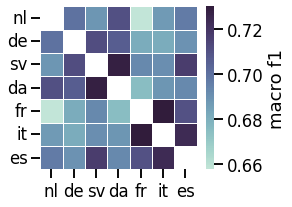

In [13]:
sns.set_context("talk")
plt.figure(figsize=(3.5, 3))
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
ax = sns.heatmap(matrix, cmap=cmap, linewidths=.5,
                 cbar_kws={"label": "macro f1"})
ax.set_xticklabels(["nl", "de", "sv", "da", "fr", "it", "es"])
ax.set_yticklabels(["nl", "de", "sv", "da", "fr", "it", "es"], rotation=0)
plt.savefig("language_agreement.pdf", bbox_inches="tight")

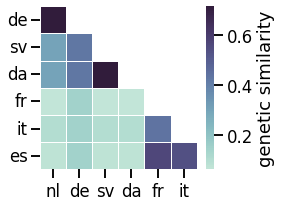

In [20]:
plt.figure(figsize=(3.5, 3))
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
ax = sns.heatmap(matrix_l2v[1:, :-1], cmap=cmap, mask=np.triu(matrix_l2v)[1:, :-1], linewidths=.5,
                 cbar_kws={"label": "genetic similarity"})
ax.set_yticklabels(["de", "sv", "da", "fr", "it", "es"], rotation=0)
ax.set_xticklabels(["nl", "de", "sv", "da", "fr", "it"])
plt.savefig("language_similarity.pdf", bbox_inches="tight")

## 4. Visualise the correlation in a scatter plot

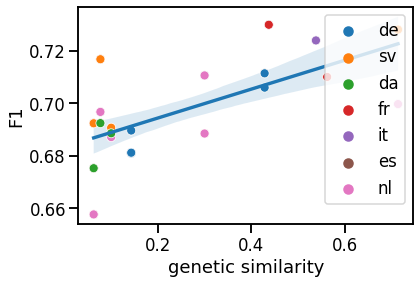

In [46]:
import scipy.stats

scipy.stats.pearsonr(
    [x for x in matrix.reshape(-1).tolist() if not math.isnan(x)],
    [x for x in matrix_l2v.reshape(-1).tolist() if not math.isnan(x)])
y = [x for x in matrix.reshape(-1).tolist() if not math.isnan(x)]
x = [x for x in matrix_l2v.reshape(-1).tolist() if not math.isnan(x)]
hue = [l for i in range(7) for j, l in enumerate(["nl", "de", "sv", "da", "fr", "it", "es"]) if i != j]
sns.regplot(x=x, y=y, scatter_kws={"alpha": 0.4}, scatter=False)
sns.scatterplot(x=x, y=y, hue=hue)
plt.xlabel("genetic similarity")
plt.ylabel("F1")
plt.show()